In [129]:
print("Python běží!")

Python běží!


In [130]:
import sys

sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install -r ../../pip-dependencies.txt

Defaulting to user installation because normal site-packages is not writeable


In [131]:
import my_libs as ml
from my_libs.tools import *
from my_libs.fft import *
from my_libs.colors import *
from my_libs.img import images
from my_libs.img.processing import *

In [132]:
ml.tools.printf("Hello world!")

Hello world!

# CVIČENÍ 9: OBČANSKÝ PRŮKAZ

In [133]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

Vytvořte  program  pro  strojové  odečítání  údajů  z občanského  průkazu  ČR. Průkaz může být  vůči kameře libovolně  otočen,  a  to  i  mimo  rovinu  obrazu. Pro jednoduchost uvažujte pouze jednu  variantu  se strojově čitelnými údaji vydávanou v letech 2012-2014.

Načtěte vzorový obraz `obcansky_prukaz_cr_sablona_2012_2014.png`. 
- Pomocí  metody  SIFT  najděte zájmové body a extrahujte z jejich  okolí deskriptory. 
- Načtěte  jeden z  testovacích  obrazů z archivu  cv09.zip a  shodným způsobem  jako u vzorového  obrazu  na něm detekujte zájmové body a extrahujte jejich deskriptory. 
- Každému  bodu  ze  vzorového  obrazu  přiřaďte  nejpodobnější  bod z testovacího obrazu  porovnáním  jejich  deskriptorů.  Odfiltrujte nejednoznačné  korespondence přiřazení  dle  poměru vzdáleností nejbližšího a druhého nejbližšího souseda. 
- Na  základě  lokálních  korespondencí  odhadněte  projektivní geometrickou transformaci  mezi  oběma  obrazy  a  vykreslete  přesnou pozici průkazu vyznačením jeho hran na testovacím obrázku. 
- Vyřízněte  průkaz  z testovacího obrazu a zarovnejte tak, aby bylo možné  ze  známých  (a  vždy  stejných)  pozic  odečíst  údaje.  Příklad zarovnaného průkazu je na obrázku `10_cze_id.jpg`. 
- V samostatném okně zobrazte fotografii  majitele  průkazu  a  do  ní připište  jeho  jméno  a  příjmení  odečtená  ze  zarovnaného  průkazu pomocí některého z nástrojů OCR, např. easyocr.

## Tipi jak na to

- SIFT
  - [tutorial_py_feature_homography](https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html) 
  - [tutorial_feature_homography](https://docs.opencv.org/3.4/d7/dff/tutorial_feature_homography.html) 
  - [sift](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_sift.html#sphx-glr-auto-examples-features-detection-plot-sift-py) 

- Přiřazení nejpodobnějších bodů:
  - [bf_matcher](https://docs.opencv.org/3.4/d3/da1/classcv_1_1BFMatcher.html) 
  - [flann_based_matcher](https://docs.opencv.org/3.4/d5/d6f/tutorial_feature_flann_matcher.html)

- Transformace obrazu:
  - [plot_geometric](https://scikit-image.org/docs/stable/auto_examples/transform/plot_geometric.html#sphx-glr-auto-examples-transform-plot-geometric-py) 
  - estimate transform - projektivní transformace
  - perspective transform - perspektivní transformace

In [134]:
folder = 'data/'
solution_file = "10_cze_id.jpg"
template_file = "obcansky_prukaz_cr_sablona_2012_2014.png"

In [135]:
# Filter images
picture_files = images.find(folder, "jpg")
picture_files.sort()

for i in range(len(picture_files)):
    if picture_files[i].find(solution_file) != -1:
        picture_files.pop(i)
        break

number_of_images = len(picture_files)
print("Number of images: ", number_of_images)

# Load images
imgs = images.load(picture_files)


Current working directory: /home/pytel/Skola/TUL-navazující_studium/3. semestr/PVI-Pocitacove_videni/cviceni/cv09, files: 
PA10_30.jpg
HS10_12.jpg
10_cze_id.jpg
TA10_01.jpg
HA10_06.jpg
KA10_01.jpg
CA10_01.jpg
KS10_02.jpg
TS10_01.jpg
Number of images:  8


libpng warning: iCCP: known incorrect sRGB profile


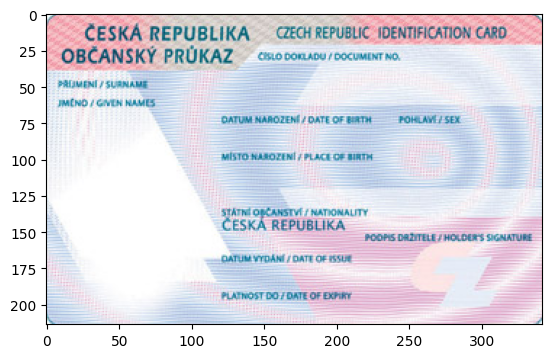

In [136]:
# Load template
img_template_bgr = cv2.imread(folder + template_file)
img_template = cv2.cvtColor(img_template_bgr, cv2.COLOR_BGR2RGB)

# visualize template
plt.imshow(img_template)

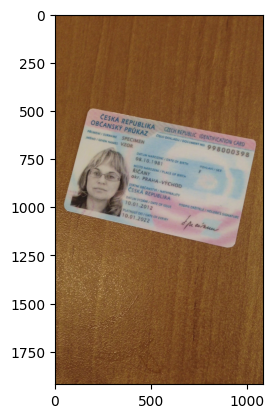

In [137]:
test_file = "TA10_01.jpg"

# Load test image
img_bgr = cv2.imread(folder + test_file)
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# visualize
plt.imshow(img)

## Nalezení zájmových bodů pomocí SIFT

In [138]:
MIN_MATCH_COUNT = 10
FLANN_INDEX_KDTREE = 1
DISTANCE_THRESHOLD = 0.7

In [139]:
# imgs to gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_template_gray = cv2.cvtColor(img_template, cv2.COLOR_BGR2GRAY)

### SIFT

In [140]:
# Initiate SIFT detector
sift = cv.SIFT_create()


def run_SIFT(img_template_gray, img_gray, min_match_count = MIN_MATCH_COUNT, flann_index_kdtree = FLANN_INDEX_KDTREE, distance_treshold = DISTANCE_THRESHOLD):
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img_template_gray, None)
    kp2, des2 = sift.detectAndCompute(img_gray, None)

    index_params = dict(algorithm = flann_index_kdtree, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < distance_treshold*n.distance:
            good.append(m)

    # if not enough matches are found
    if len(good)<min_match_count:
        raise Exception("Not enough matches are found - {}/{}".format(len(good), min_match_count))

    # Get first 10 matches.
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

    return kp1, kp2, good, M, mask

kp1, kp2, good, M, mask = run_SIFT(img_template_gray, img_gray)

### Obdelnik kolem obrázku

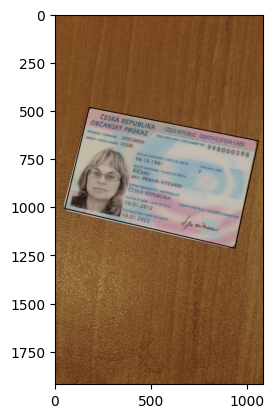

In [141]:
def get_corners_of_image(img):
    h, w = img.shape
    return np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

def draw_rectangle(img, corners, color = (0, 0, 0), size = 3):
    for i in range(4):
        cv.line(img, (int(corners[i,0,0]), int(corners[i,0,1])), (int(corners[(i+1)%4,0,0]), int(corners[(i+1)%4,0,1])), color, size)

obj_corners = get_corners_of_image(img_template_gray)
scene_corners = cv.perspectiveTransform(obj_corners, M)
img_lines = img.copy()
draw_rectangle(img_lines, scene_corners)

plt.imshow(img_lines)

## Spojeni klíčových bodů čarou

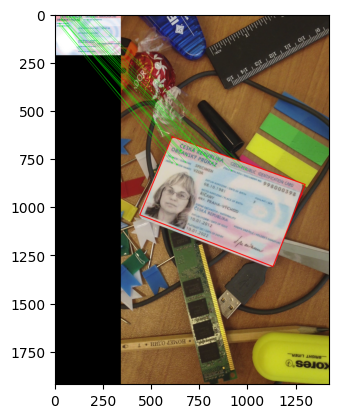

(<matplotlib.image.AxesImage at 0x72c0505b0c50>, None)

In [ ]:
# Draw matches
def draw_matches(img1, kp1, img2, kp2, good, matchesMask, color = (0, 255, 0)):
    draw_params = dict(matchColor = color,
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    return cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

matchesMask = mask.ravel().tolist()
img_matches = draw_matches(img_template, kp1, img, kp2, good, matchesMask)

# visualize
plt.imshow(img_matches)
plt.show()

## Výřez obrázku

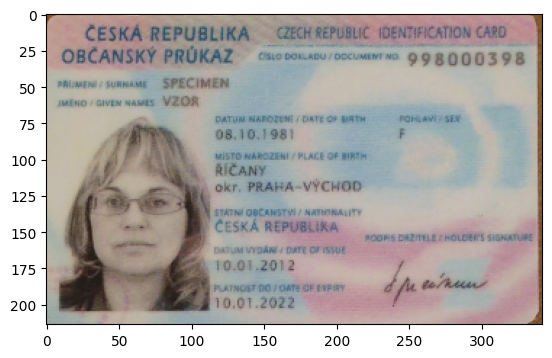

In [142]:
def inverse_transform_of_homography(img, img_template_gray, M):
    """
    Inverse transformation of the image using homography matrix.
    Compute the inverse transformation of the image using homography matrix.

    Args:
        img: input image
        img_template_gray: template image
        M: transformation matrix

    Returns:
        img_transformed: transformed image
    """
    M_inversed = np.linalg.inv(M)
    x_size = img_template_gray.shape[1]
    y_size = img_template_gray.shape[0]
    img_transformed = cv.warpPerspective(img, M_inversed, (x_size, y_size))
    return img_transformed

# visualize
img_transformed = inverse_transform_of_homography(img, img_template_gray, M)
plt.imshow(img_transformed)

## Rozpoznání textu a výřez fotografie

## Pro všechny obrázky

CA10_01.jpg
HA10_06.jpg
HS10_12.jpg
KA10_01.jpg
KS10_02.jpg
PA10_30.jpg
TA10_01.jpg
TS10_01.jpg


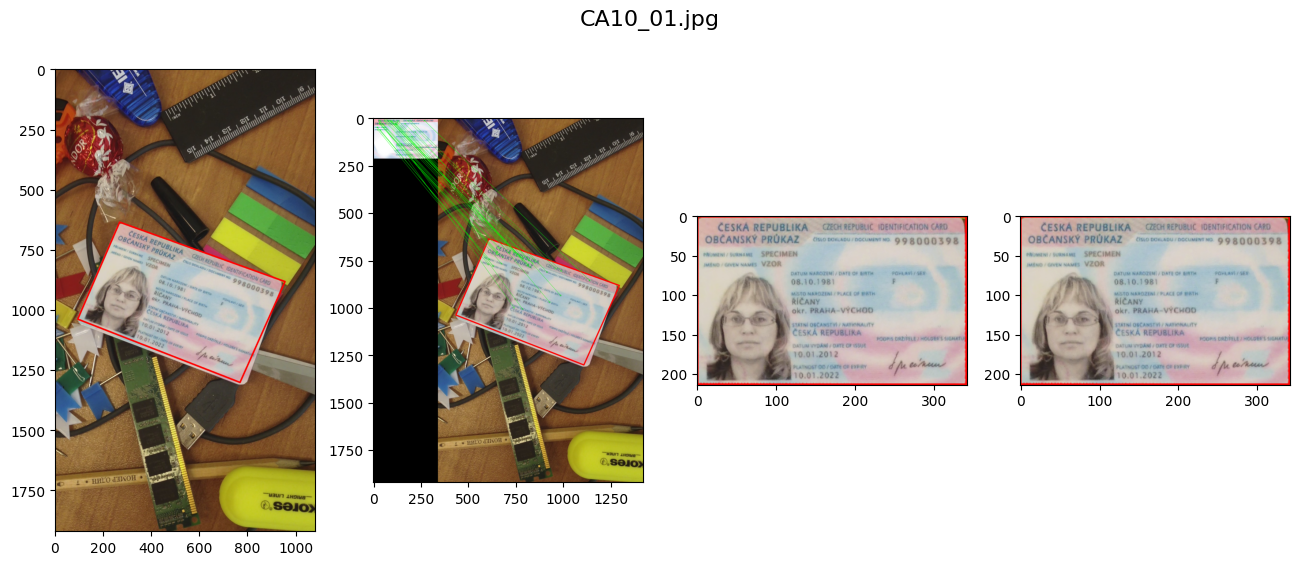

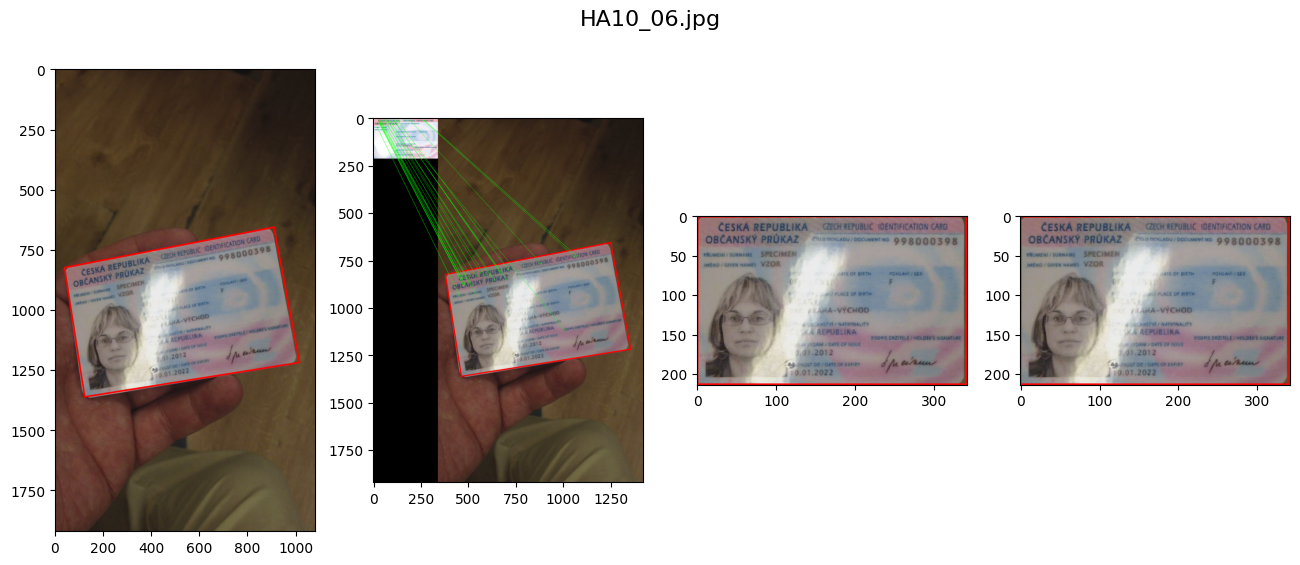

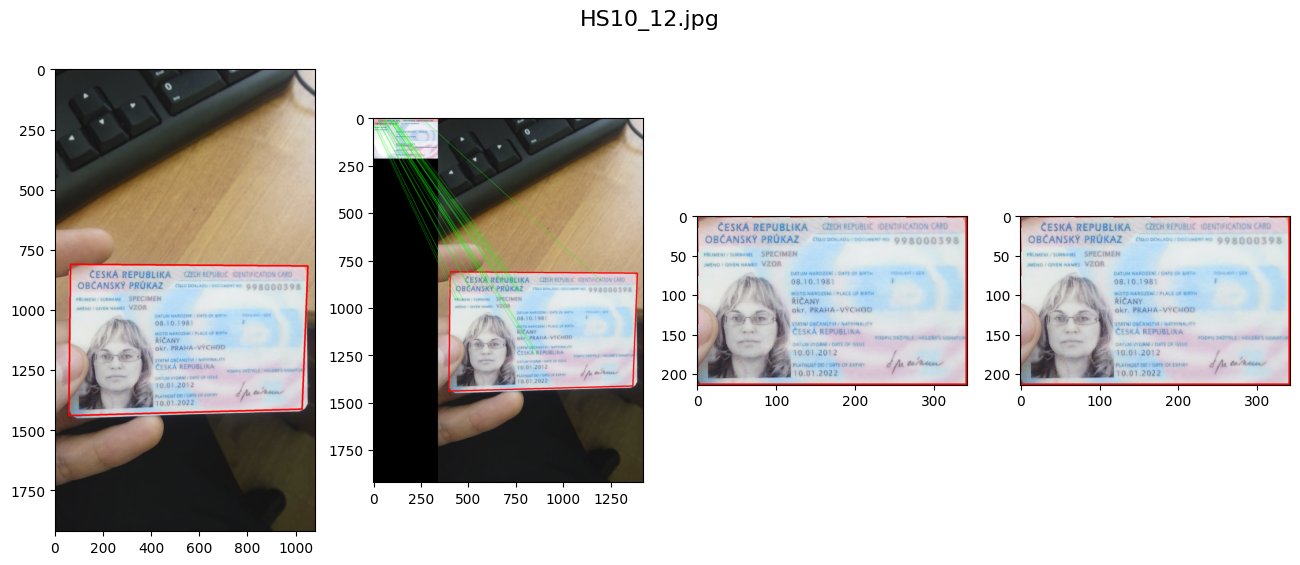

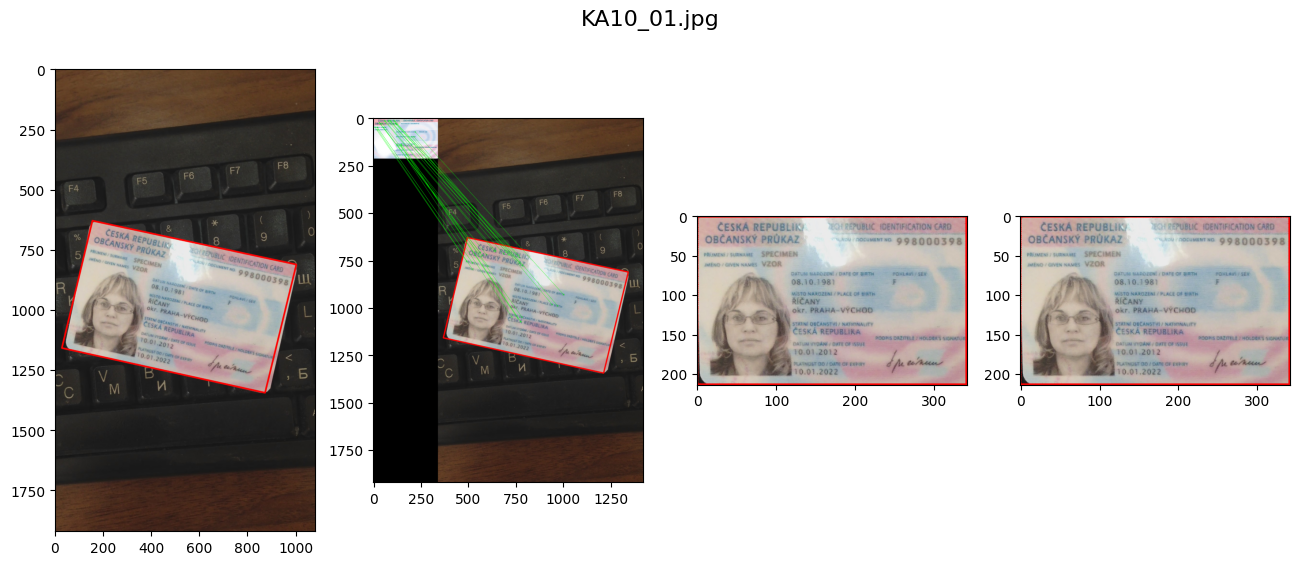

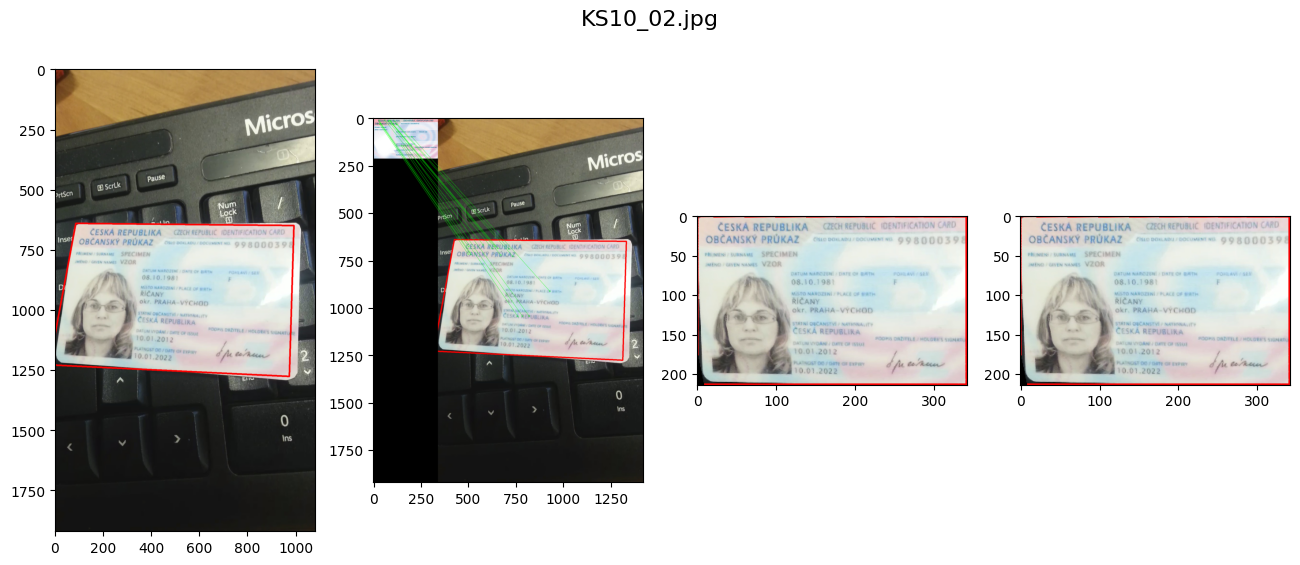

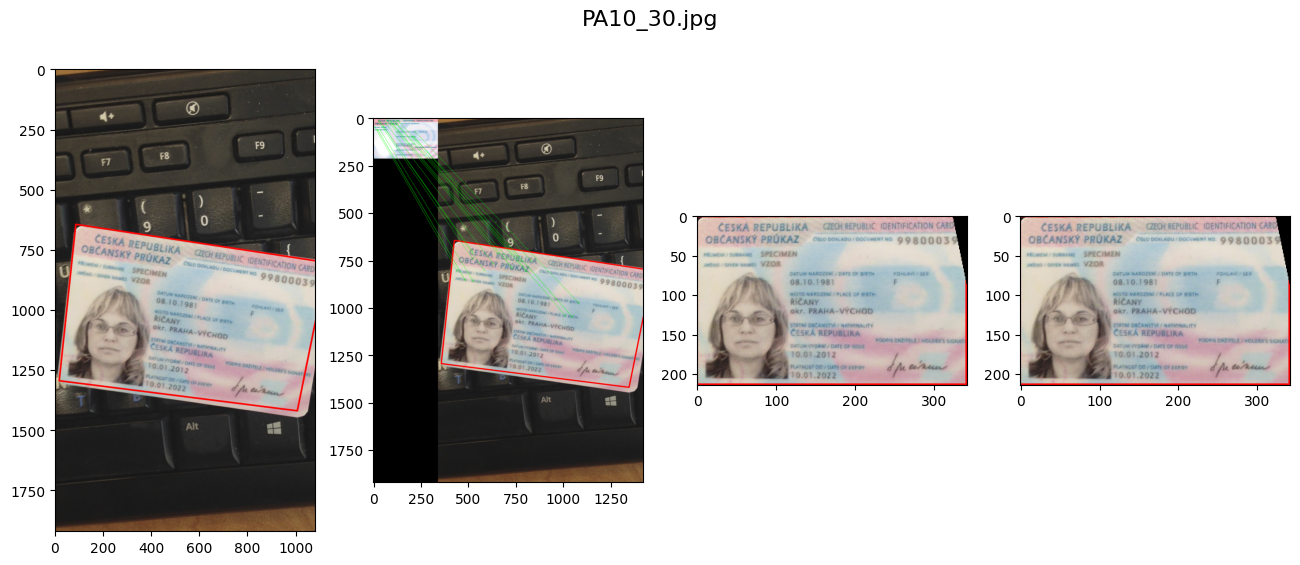

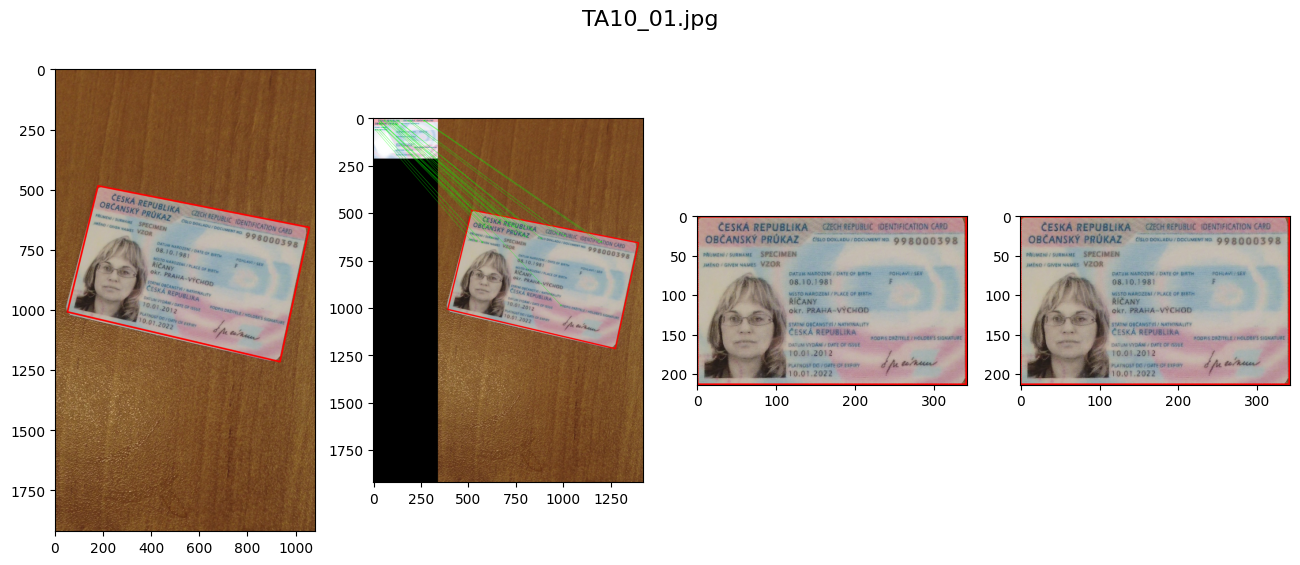

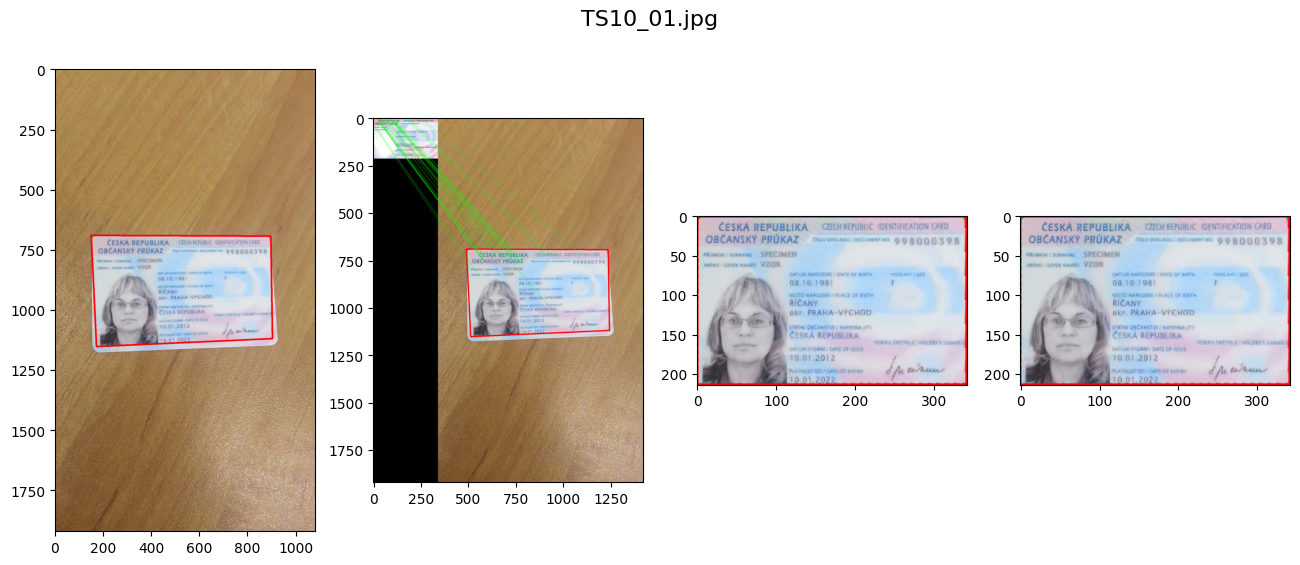

In [148]:
# Initiate SIFT detector
sift = cv.SIFT_create()

rectangle_color = (255, 0, 0)
line_color = (0, 255, 0)
size = 6

for img_original, file_name in zip(imgs, picture_files):
    file_name = file_name.split('/')[-1]
    print(file_name)
    img = img_original.copy()
    img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
    try:
        kp1, kp2, good, M, mask = run_SIFT(img_template_gray, img_gray)
        obj_corners = get_corners_of_image(img_template_gray)
        scene_corners = cv.perspectiveTransform(obj_corners, M)
        draw_rectangle(img, scene_corners, rectangle_color, size)
        img_transformed = inverse_transform_of_homography(img, img_template_gray, M)

        # visualize
        plt.figure(figsize=(16, 6))
        # title
        plt.suptitle(file_name, fontsize=16)
        # original image
        plt.subplot(1, 4, 1)
        plt.imshow(img)
        
        # draw matches
        plt.subplot(1, 4, 2)
        img_matches = draw_matches(img_template, kp1, img, kp2, good, mask.ravel().tolist(), line_color)
        plt.imshow(img_matches)

        # transformed image
        plt.subplot(1, 4, 3)
        plt.imshow(img_transformed)

        # croped face and recognized text
        plt.subplot(1, 4, 4)        
        plt.imshow(img_transformed)
        #TODO
    except Exception as e:
        print(e)
    
    